In [9]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
import requests

# get the directory of the current file
current_dir_win = os.path.dirname(os.path.realpath('__file__'))
current_dir_linux = current_dir_win.replace('\\', '/')

# print how many gpu's are available
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [10]:
images_dirs = []

images_1_dir = f"{current_dir_win}/data/images_001/images" # this is for debuggin and beta testing
images_dirs.append(f"{current_dir_win}/data/images_001/images")
images_dirs.append(f"{current_dir_win}/data/images_002/images")
images_dirs.append(f"{current_dir_win}/data/images_003/images")
images_dirs.append(f"{current_dir_win}/data/images_004/images")
images_dirs.append(f"{current_dir_win}/data/images_005/images")
images_dirs.append(f"{current_dir_win}/data/images_006/images")
images_dirs.append(f"{current_dir_win}/data/images_007/images")
images_dirs.append(f"{current_dir_win}/data/images_008/images")
images_dirs.append(f"{current_dir_win}/data/images_009/images")
images_dirs.append(f"{current_dir_win}/data/images_010/images")
images_dirs.append(f"{current_dir_win}/data/images_011/images")
images_dirs.append(f"{current_dir_win}/data/images_012/images")


data_folder_dir = f"{current_dir_win}\\data"
len(images_dirs)

12

In [11]:
def view_random_images(target_dir, num_images=4):
    target_folder = target_dir
    random_images = random.sample(os.listdir(target_folder), 4)
    fig, axes = plt.subplots(1, 4, figsize=(10, 10))
    axes = axes.flatten()
    for img, ax in zip(random_images, axes):
        img = mpimg.imread(target_folder + "/" + img)
        ax.imshow(img)
        ax.axis("off")
    plt.tight_layout()
    plt.show()

In [12]:
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True) # save only the best model to file

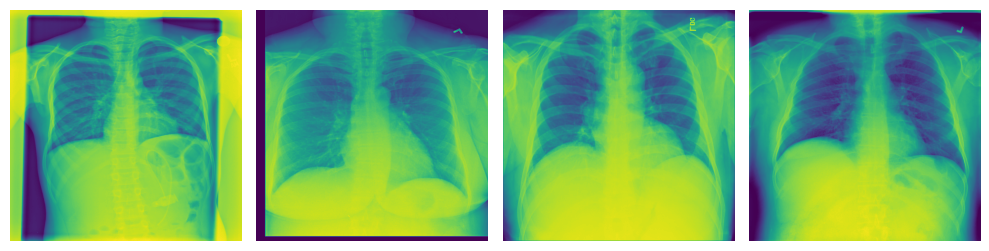

In [13]:
view_random_images(images_1_dir, 1)

In [14]:
all_labels = pd.read_csv(f"{current_dir_win}/data/Data_Entry_2017.csv")

len(all_labels)

112120

In [15]:
# delete the all columns except the image index, labels, patient age and patient gender
all_labels = all_labels.drop(["Follow-up #", "Patient ID", "Patient Age", "View Position", "OriginalImage[Width", "Height]", "OriginalImagePixelSpacing[x", "y]", "Unnamed: 11", "Patient Gender"], axis=1)

all_labels.head()

,Image Index,Finding Labels
0,00000001_000.png,Cardiomegaly
1,00000001_001.png,Cardiomegaly|Emphysema
2,00000001_002.png,Cardiomegaly|Effusion
3,00000002_000.png,No Finding
4,00000003_000.png,Hernia


### Droping the bad labels which are not in the train.txt

In [24]:
# get the new_labels_all.csv file
new_labels_all = pd.read_csv(f"{current_dir_win}/data/new_labels_all.csv")

new_labels_all.head()

,Patient ID,Image ID,Reader ID,Fracture,Pneumothorax,Airspace opacity,Nodule/mass,Set ID
0,13,00000013_008.png,4295367682,NO,YES,YES,NO,test
1,13,00000013_008.png,4295232296,NO,NO,YES,NO,test
2,13,00000013_008.png,4323195249,NO,NO,YES,NO,test
3,13,00000013_026.png,4323195249,NO,YES,NO,NO,test
4,13,00000013_026.png,4295194124,NO,YES,NO,NO,test


In [16]:
all_labels_original = all_labels.copy()
# get the /data/train_val_list.txt's + /data/test_list.txt's lines in a list
with open(f"{current_dir_win}/data/train_val_list.txt", "r") as f:
    train_val_list = f.readlines()
with open(f"{current_dir_win}/data/test_list.txt", "r") as f:
    test_list = f.readlines()

# combine the train_val_list and test_list
lines_in_valtxt = train_val_list + test_list

In [17]:
# drop the rows that are not in the train_val_list.txt
all_labels = all_labels[all_labels['Image Index'].isin(lines_in_valtxt)]

len(all_labels), len(lines_in_valtxt)

(2, 112120)

In [19]:
# list all label names that are in the all_labels_original but not in the all_labels

lost_row_indexes = []

for index, row in all_labels_original.iterrows():
    if row['Image Index'] not in lines_in_valtxt:
        lost_row_indexes.append(index)

len(lost_row_indexes)

112118

In [11]:
# convert the all_labels finding labels column into mulitple true/false columns
all_labels = all_labels.join(all_labels["Finding Labels"].str.get_dummies(sep="|"))
# drop finding labels column
all_labels = all_labels.drop("Finding Labels", axis=1)

all_labels

,Image Index,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
2,00000001_002.png,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
3,00000002_000.png,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
12,00000004_000.png,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112100,00030789_000.png,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
112106,00030793_000.png,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
112108,00030795_000.png,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
112114,00030801_000.png,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [12]:
# geth the all columns of the all_labels dataframe
all_labels.columns

Index(['Image Index', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
       'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass',
       'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia',
       'Pneumothorax'],
      dtype='object')

In [13]:
def get_the_image_count(dir):
    image_names = os.listdir(dir)

    # check how many of them is in the all_labels dataframe
    image_count = 0
    for image_name in image_names:
        if image_name in all_labels['Image Index'].values:
            image_count += 1

    return image_count

In [15]:
# get the first 4999 rows from all_labels
images_1_image_count = get_the_image_count(images_dirs[0])
images_2_image_count = get_the_image_count(images_dirs[1])
images_3_image_count = get_the_image_count(images_dirs[2])
images_4_image_count = get_the_image_count(images_dirs[3])
images_5_image_count = get_the_image_count(images_dirs[4])
images_6_image_count = get_the_image_count(images_dirs[5])
images_7_image_count = get_the_image_count(images_dirs[6])
images_8_image_count = get_the_image_count(images_dirs[7])
images_9_image_count = get_the_image_count(images_dirs[8])
images_10_image_count = get_the_image_count(images_dirs[9])
images_11_image_count = get_the_image_count(images_dirs[10])
images_12_image_count = get_the_image_count(images_dirs[11])

print(images_1_image_count)


images_1_labels = all_labels[:images_1_image_count]
images_2_labels = all_labels[images_1_image_count:images_1_image_count + images_2_image_count]
images_3_labels = all_labels[images_1_image_count + images_2_image_count:images_1_image_count + images_2_image_count + images_3_image_count]
images_4_labels = all_labels[images_1_image_count + images_2_image_count + images_3_image_count:images_1_image_count + images_2_image_count + images_3_image_count + images_4_image_count]
images_5_labels = all_labels[images_1_image_count + images_2_image_count + images_3_image_count + images_4_image_count:images_1_image_count + images_2_image_count + images_3_image_count + images_4_image_count + images_5_image_count]
images_6_labels = all_labels[images_1_image_count + images_2_image_count + images_3_image_count + images_4_image_count + images_5_image_count:images_1_image_count + images_2_image_count + images_3_image_count + images_4_image_count + images_5_image_count + images_6_image_count]
images_7_labels = all_labels[images_1_image_count + images_2_image_count + images_3_image_count + images_4_image_count + images_5_image_count + images_6_image_count:images_1_image_count + images_2_image_count + images_3_image_count + images_4_image_count + images_5_image_count + images_6_image_count + images_7_image_count]
images_8_labels = all_labels[images_1_image_count + images_2_image_count + images_3_image_count + images_4_image_count + images_5_image_count + images_6_image_count + images_7_image_count:images_1_image_count + images_2_image_count + images_3_image_count + images_4_image_count + images_5_image_count + images_6_image_count + images_7_image_count + images_8_image_count]
images_9_labels = all_labels[images_1_image_count + images_2_image_count + images_3_image_count + images_4_image_count + images_5_image_count + images_6_image_count + images_7_image_count + images_8_image_count:images_1_image_count + images_2_image_count + images_3_image_count + images_4_image_count + images_5_image_count + images_6_image_count + images_7_image_count + images_8_image_count + images_9_image_count]
images_10_labels = all_labels[images_1_image_count + images_2_image_count + images_3_image_count + images_4_image_count + images_5_image_count + images_6_image_count + images_7_image_count + images_8_image_count + images_9_image_count:images_1_image_count + images_2_image_count + images_3_image_count + images_4_image_count + images_5_image_count + images_6_image_count + images_7_image_count + images_8_image_count + images_9_image_count + images_10_image_count]
images_11_labels = all_labels[images_1_image_count + images_2_image_count + images_3_image_count + images_4_image_count + images_5_image_count + images_6_image_count + images_7_image_count + images_8_image_count + images_9_image_count + images_10_image_count:images_1_image_count + images_2_image_count + images_3_image_count + images_4_image_count + images_5_image_count + images_6_image_count + images_7_image_count + images_8_image_count + images_9_image_count + images_10_image_count + images_11_image_count]
images_12_labels = all_labels[images_1_image_count + images_2_image_count + images_3_image_count + images_4_image_count + images_5_image_count + images_6_image_count + images_7_image_count + images_8_image_count + images_9_image_count + images_10_image_count + images_11_image_count:images_1_image_count + images_2_image_count + images_3_image_count + images_4_image_count + images_5_image_count + images_6_image_count + images_7_image_count + images_8_image_count + images_9_image_count + images_10_image_count + images_11_image_count + images_12_image_count]

image_labels = [images_1_labels, images_2_labels, images_3_labels, images_4_labels, images_5_labels, images_6_labels, images_7_labels, images_8_labels, images_9_labels, images_10_labels, images_11_labels, images_12_labels]
label_image_counts = [images_1_image_count, images_2_image_count, images_3_image_count, images_4_image_count, images_5_image_count, images_6_image_count, images_7_image_count, images_8_image_count, images_9_image_count, images_10_image_count, images_11_image_count, images_12_image_count]

4032


In [16]:
image_labels[10].iloc[:5]

,Image Index,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
94999,00024718_000.png,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
95000,00024719_000.png,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
95001,00024720_000.png,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
95002,00024721_000.png,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
95003,00024722_000.png,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [17]:
def add_path_to_labels(image_labels):
    for i in range(len(image_labels)):
        for j in range(image_labels[i].iloc[0].name, image_labels[i].iloc[-1].name + 1):
            # if j in the lost_row_indexes, then skip
            if j in lost_row_indexes:
                continue
            image_labels[i].at[j, "Image Index"] = f"{current_dir_linux}/data/images_{str(i+1).zfill(3)}/images/" + image_labels[i].at[j, "Image Index"]
    return image_labels

In [18]:
image_labels_with_paths = add_path_to_labels(image_labels)

In [19]:
image_labels_with_paths[5].iloc[0]["Image Index"]

'H:/Programming/Machine_Learning/Xray_Detection/data/images_006/images/00011558_008.png'

In [91]:
# x = 8
# y = 30
# image_labels_with_paths[x].at[image_labels[x].iloc[0].name + y, "Image Index"]

In [20]:
len(images_1_labels), len(images_2_labels), len(images_12_labels)

(4032, 8508, 3529)

In [21]:
labels_in_order = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
       'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass',
       'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia',
       'Pneumothorax']

In [26]:
image_labels = image_labels_with_paths

images_train_labels = []
images_test_labels = []
train_test_split_size = 0.8

images_1_train_labels = image_labels[0][:int(images_1_image_count * train_test_split_size)]
images_1_test_labels = image_labels[0][int(images_1_image_count * train_test_split_size):]

images_train_labels.append(image_labels[0][:int(images_1_image_count * train_test_split_size)])
images_train_labels.append(image_labels[1][:int(images_2_image_count * train_test_split_size)])
images_train_labels.append(image_labels[2][:int(images_3_image_count * train_test_split_size)])
images_train_labels.append(image_labels[3][:int(images_4_image_count * train_test_split_size)])
images_train_labels.append(image_labels[4][:int(images_5_image_count * train_test_split_size)])
images_train_labels.append(image_labels[5][:int(images_6_image_count * train_test_split_size)])
images_train_labels.append(image_labels[6][:int(images_7_image_count * train_test_split_size)])
images_train_labels.append(image_labels[7][:int(images_8_image_count * train_test_split_size)])
images_train_labels.append(image_labels[8][:int(images_9_image_count * train_test_split_size)])
images_train_labels.append(image_labels[9][:int(images_10_image_count * train_test_split_size)])
images_train_labels.append(image_labels[10][:int(images_11_image_count * train_test_split_size)])
images_train_labels.append(image_labels[11][:int(images_12_image_count * train_test_split_size)])

images_test_labels.append(image_labels[0][int(images_1_image_count * train_test_split_size):])
images_test_labels.append(image_labels[1][int(images_2_image_count * train_test_split_size):])
images_test_labels.append(image_labels[2][int(images_3_image_count * train_test_split_size):])
images_test_labels.append(image_labels[3][int(images_4_image_count * train_test_split_size):])
images_test_labels.append(image_labels[4][int(images_5_image_count * train_test_split_size):])
images_test_labels.append(image_labels[5][int(images_6_image_count * train_test_split_size):])
images_test_labels.append(image_labels[6][int(images_7_image_count * train_test_split_size):])
images_test_labels.append(image_labels[7][int(images_8_image_count * train_test_split_size):])
images_test_labels.append(image_labels[8][int(images_9_image_count * train_test_split_size):])
images_test_labels.append(image_labels[9][int(images_10_image_count * train_test_split_size):])
images_test_labels.append(image_labels[10][int(images_11_image_count * train_test_split_size):])
images_test_labels.append(image_labels[11][int(images_12_image_count * train_test_split_size):])


images_all_train_labels = pd.concat(images_train_labels)
images_all_test_labels = pd.concat(images_test_labels)

len(images_1_train_labels), len(images_1_test_labels)

(3225, 807)

In [27]:
len(images_all_train_labels), len(images_all_test_labels)

(69213, 17311)

In [23]:
images_train_labels[0]

,Image Index,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,H:/Programming/Machine_Learning/Xray_Detection...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,H:/Programming/Machine_Learning/Xray_Detection...,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
2,H:/Programming/Machine_Learning/Xray_Detection...,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
3,H:/Programming/Machine_Learning/Xray_Detection...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
12,H:/Programming/Machine_Learning/Xray_Detection...,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4042,H:/Programming/Machine_Learning/Xray_Detection...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4043,H:/Programming/Machine_Learning/Xray_Detection...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4044,H:/Programming/Machine_Learning/Xray_Detection...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4045,H:/Programming/Machine_Learning/Xray_Detection...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [24]:
images_train_labels[0].iloc[random.randint(0, len(images_1_train_labels))]["Image Index"]

'H:/Programming/Machine_Learning/Xray_Detection/data/images_001/images/00000248_005.png'

In [28]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,samplewise_center=True, samplewise_std_normalization= True)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, samplewise_center=True, samplewise_std_normalization= True)


train_generator = train_datagen.flow_from_dataframe(
    dataframe = images_all_train_labels,
    directory=None,
    x_col="Image Index",
    y_col=['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
       'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass',
       'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia',
       'Pneumothorax'],
    target_size=(224, 224),
    batch_size=32,
    class_mode="raw",
    shuffle=True,
    seed=42,
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=images_all_test_labels,
    directory=None,
    x_col="Image Index",
    y_col=['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
            'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass',
            'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia',
            'Pneumothorax'],
    target_size=(224, 224),
    batch_size=32,
    class_mode="raw",
    shuffle=True,
    seed=42,
)

Found 69213 validated image filenames.
Found 17311 validated image filenames.


## All Data is prepended, only thing left is to create and train model (: